In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
ts_df = pd.read_csv("./data/SWOW_prediction/eval/time_series/nyt_ts_df.csv")

ts_df = (
    ts_df.groupby(["words", "year", "property"])[["outputs_z", "count"]]
    .mean()
    .reset_index()
)
ts_df = ts_df.loc[ts_df["count"] >= 50]

In [3]:
indexed_df = ts_df.set_index(["words"])  # red: republicans, blue: democrats
elections = {
    1988: "tab:red",
    1992: "tab:blue",
    1996: "tab:blue",
    2000: "tab:red",
    2004: "tab:red",
}
blue_years = {year for year in elections if elections[year] == "tab:blue"}
red_years = {year for year in elections if elections[year] == "tab:red"}
blue_years, red_years

({1992, 1996}, {1988, 2000, 2004})

In [4]:
# Mapping stems to full words
mapping = {
    "treati": "treaty",
    "salari": "salary",
    "judici": "judiciary",
    "poverti": "poverty",
    "navi": "navy",
    "militari": "military",
    "regulatori": "regulatory",
    "duti": "duty",
    "treasuri": "treasury",
    "recoveri": "recovery",
    "armi": "army",
    "freedeliveri": "freedelivery",
    "busi": "business",
    "privaci": "privacy",
    "bankruptci:": "bankruptcy",
    "safeti": "safety",
    "bureaucraci": "bureaucracy",
    "selfsuffici": "selfsufficy",
    "alreadi": "already",
    "bankruptci": "bankruptcy",
    "monetari": "monetary",
    "simplifi": "simplify",
    "germani": "germany",
    "subsidiari": "subsidiary",
    "secondari": "secondary",
    "machineri": "machinery",
    "mandatori": "mandatory",
    "migratori": "migratory",
    "fisheri": "fishery",
    "equiti": "equity",
    "postsecondari": "postsecondary",
    "discriminatori": "discriminatory",
    "penalti": "penalty",
    "forestri": "forestry",
    "difficulti": "difficulty",
    "elementari": "elementary",
    "pariti": "parity",
    "secretari": "secretary",
    "slurri": "slurry",
    "dairi": "dairy",
    "duli": "duly",
    "daili": "daily",
    "antipoverti": "antipoverty",
    "liberti": "liberty",
    "laboratori": "laboratory",
    "judiciari": "judiciary",
    "wealthi": "wealthy",
    "entiti": "entity",
    "faculti": "faculty",
    "conspiraci": "conspiracy",
    "surgeri": "surgery",
    "countri": "country",
    "realiti": "reality",
    "everi": "every",
    "smallbusi": "smallbusy",
    "energi": "energy",
    "discretionari": "discretionary",
    "ssi": "ssy",
    "societi": "society",
    "communiti": "community",
    "compensatori": "compensatory",
    "prioriti": "priority",
    "properti": "property",
    "liquefi": "liquefy",
    "democraci": "democracy",
    "deputi": "deputy",
    "revolutionari": "revolutionary",
    "beneficiari": "beneficiary",
    "qualiti": "quality",
    "jewri": "jewry",
    "enemi": "enemy",
    "compulsori": "compulsory",
    "economi": "econom",
    "polici": "policy",
    "famili": "family",
    "lobbi": "lobby",
    "bodi": "body",
    "victori": "victory",
    "theori": "theor",
    "countri": "country",
    "healthi": "health",
    "needi": "need",
    "primari": "primary",
    "studi": "stud",
    "territori": "territor",
    "voluntari": "voluntar",
    "deliveri": "delivery",
    "scrutini": "scrutiny",
    "necessari": "necessary",
    "philosophi": "philosoph",
    "juri": "jury",
    "speedi": "speedy",
    "basi": "basic",
    "treasuri": "treasury",
}

In [5]:
# Loading political unigram keywords from the congressional speech datase4t
keyword_file = "./data/hein-daily/keywords.txt"
topic_keywords = {}
one_grams = set()
with open(keyword_file) as f:
    lines = f.readlines()[1:]
    for line in lines:
        topic, word = line.split("|")
        word = word.strip()
        if word in mapping:
            word = mapping[word]

        topic_keywords[word] = topic.strip()
        one_grams.add(word)

len(topic_keywords), len(one_grams)

(282, 282)

In [6]:
all_words = ts_df.words.unique()
prefix_mapping = dict()
political_one_grams = set()

In [7]:
# Loading political bigram keywords from the congressional speech dataset
bigram_file = "./data/hein-daily/topic_phrases.txt"
bi_grams = set()
ending_with_i = set()
with open(bigram_file) as f:
    lines = f.readlines()[1:]
    for line in lines:
        topic, word = line.split("|")

        b1, b2 = word.split()
        topic_keywords[word.strip()] = topic.strip()
        b1 = b1.strip()
        b2 = b2.strip()
        if b1 in mapping:
            b1 = mapping[b1]
        if b2 in mapping:
            b2 = mapping[b2]

        if b1 not in prefix_mapping:

            prefix_mapping[b1] = [w for w in all_words if w.startswith(b1)]
            political_one_grams.update(
                set(prefix_mapping[b1]),
            )  # Also add the prefix words to the political unigrams
        if b2 not in prefix_mapping:

            prefix_mapping[b2] = [w for w in all_words if w.startswith(b2)]
            political_one_grams.update(set(prefix_mapping[b2]))
        for w1 in prefix_mapping[b1]:
            for w2 in prefix_mapping[b2]:
                bi_grams.add(w1 + " " + w2)


len(bi_grams)

191518

In [8]:
bi_grams

{'gospel hospitalized',
 'economics sense',
 'medication save',
 'governor goer',
 'electric continuous',
 'started payback',
 'statewide air',
 'tax revenue planning',
 'fund taxi',
 'government goo',
 'board educated',
 'special payment',
 'warning golden',
 'industrial makeshift',
 'economy plant',
 'continuously payback',
 'believe tax',
 'taxcut court',
 'warehouse know',
 'endured ward',
 'realestate economically',
 'billboard governor',
 'civilization warship',
 'drug warring',
 'hospitalized providing',
 'development tax revenue',
 'warned endowment',
 'higher waged',
 'warming continuous',
 'application equally',
 'warm united',
 'taxi incoming',
 'federated facility',
 'beet sugar cane',
 'fundraising warhead',
 'caregiver professionally',
 'goldstein businessman',
 'taxcut courtesy',
 'destroy industrious',
 'publicity privately',
 'indian schoolchildren',
 'campaigning promiscuous',
 'mend vote',
 'statement plank',
 'carefully gonzales',
 'educator fundraiser',
 'courtyard

In [9]:
political_one_grams.update(one_grams)
small_ts_df = ts_df.loc[
    (ts_df.words.isin(political_one_grams)) | (ts_df.words.isin(bi_grams))
]
small_ts_df = small_ts_df.set_index("words")
len(small_ts_df), len(ts_df)

(187770, 555064)

In [10]:
bi_gram_ts_df = pd.DataFrame()

In order to estimate moral relevance and moral polarity bigrams, we take average the two components of the bigram.

In [11]:
with open(bigram_file) as f:
    lines = f.readlines()[1:]
    print(len(lines))
    for i, line in enumerate(lines):
        if i % 100 == 0:
            print(i, len(lines))

        topic, word = line.split("|")

        b1, b2 = word.split()
        b1 = b1.strip()
        b2 = b2.strip()
        if b1 in mapping:
            b1 = mapping[b1]
        if b2 in mapping:
            b2 = mapping[b2]

        b1_df = small_ts_df.loc[
            small_ts_df.index.isin(prefix_mapping[b1])
        ].reset_index()

        b2_df = small_ts_df.loc[
            small_ts_df.index.isin(prefix_mapping[b2])
        ].reset_index()

        if len(b1_df) == 0 or len(b2_df) == 0:
            continue
        b1_df = (
            b1_df.groupby(["property", "year"])[["count", "outputs_z"]]
            .mean()
            .reset_index()
        )
        b2_df = (
            b2_df.groupby(["property", "year"])[["count", "outputs_z"]]
            .mean()
            .reset_index()
        )

        joint_df = (
            b1_df.set_index(["property", "year"])
            .join(b2_df.set_index(["property", "year"]), lsuffix="_1", rsuffix="_2")
            .reset_index()
        )
        joint_df["count"] = (joint_df["count_1"] + joint_df["count_2"]) / 2
        joint_df["outputs_z"] = (joint_df["outputs_z_1"] + joint_df["outputs_z_2"]) / 2
        joint_df["topic"] = topic
        joint_df["words"] = word.strip()

        bi_gram_ts_df = pd.concat((bi_gram_ts_df, joint_df), ignore_index=True)

7555
0 7555
100 7555
200 7555
300 7555
400 7555
500 7555
600 7555
700 7555
800 7555
900 7555
1000 7555
1100 7555
1200 7555
1300 7555
1400 7555
1500 7555
1600 7555
1700 7555
1800 7555
1900 7555
2000 7555
2100 7555
2200 7555
2300 7555
2400 7555
2500 7555
2600 7555
2700 7555
2800 7555
2900 7555
3000 7555
3100 7555
3200 7555
3300 7555
3400 7555
3500 7555
3600 7555
3700 7555
3800 7555
3900 7555
4000 7555
4100 7555
4200 7555
4300 7555
4400 7555
4500 7555
4600 7555
4700 7555
4800 7555
4900 7555
5000 7555
5100 7555
5200 7555
5300 7555
5400 7555
5500 7555
5600 7555
5700 7555
5800 7555
5900 7555
6000 7555
6100 7555
6200 7555
6300 7555
6400 7555
6500 7555
6600 7555
6700 7555
6800 7555
6900 7555
7000 7555
7100 7555
7200 7555
7300 7555
7400 7555
7500 7555


In [12]:
bi_gram_ts_df["words"] = bi_gram_ts_df["words"].apply(lambda w: w.strip())
bi_gram_ts_df = bi_gram_ts_df.dropna().reset_index(drop=True)

In [13]:
bi_gram_ts_df.sample()  # outputs_z_1: moral score for the first word, outputs_z_2: moral score for the second word, outputs_z: average moral score for the two words

,property,year,count_1,outputs_z_1,count_2,outputs_z_2,count,outputs_z,topic,words
103673,previous_link,2003,4235.5,0.109912,2516.0,-0.75588,3375.75,-0.322984,education,import educ


In [14]:
bigram_category = bi_gram_ts_df.groupby("topic")["words"].apply(list).to_dict()
small_ts_df = pd.concat(
    (
        small_ts_df.reset_index(),
        bi_gram_ts_df[["words", "year", "property", "count", "outputs_z"]],
    ),
    ignore_index=True,
)
small_ts_df = small_ts_df.dropna().reset_index(drop=True)
len(small_ts_df)

489944

In [15]:
rest_df = ts_df.loc[
    ~ts_df.words.isin(small_ts_df.words.unique())
].reset_index()  # moral association scores for all the other words
len(rest_df)

367294

In [16]:
ts_df = pd.concat((small_ts_df, rest_df), ignore_index=True)
words = ts_df.words.unique()

In [17]:
result = []
blue_year_df = ts_df.loc[(ts_df.year.isin(blue_years)) & (ts_df["count"] >= 50)]
red_election_year_df = ts_df.loc[(ts_df.year.isin(red_years)) & (ts_df["count"] >= 50)]


blue_counts = blue_year_df.groupby(["words", "property"]).outputs_z.count().to_dict()
red_counts = (
    red_election_year_df.groupby(["words", "property"]).outputs_z.count().to_dict()
)

blue_dict = (
    blue_year_df.groupby(["words", "property"]).outputs_z.mean().to_dict()
)  # Mapping words to their average moral association scores in blue years
red_dict = (
    red_election_year_df.groupby(["words", "property"]).outputs_z.mean().to_dict()
)  # Mapping words to their average moral association scores in red years
for word in words:
    new_row = {"word": word}
    for pr in ["previous_link", "polarity"]:
        if (word, pr) in blue_dict and (word, pr) in red_dict:
            if (
                blue_counts[(word, pr)] >= 2 and red_counts[(word, pr)] >= 2
            ):  # Making sure that the words appear in at least two elections for each party
                new_row[f"{pr}_blue_election"] = blue_dict[(word, pr)]
                new_row[f"{pr}_red_election"] = red_dict[(word, pr)]
        else:
            continue
    result.append(new_row)


party_election_df = (
    pd.DataFrame(result).drop_duplicates().dropna().reset_index(drop=True)
)  # This is a dataset of words moral association scores averaged in blue and red elections

party_election_df["polarity_diff"] = (
    party_election_df["polarity_blue_election"]
    - party_election_df["polarity_red_election"]
)
party_election_df["relevance_diff"] = (
    party_election_df["previous_link_blue_election"]
    - party_election_df["previous_link_red_election"]
)


party_election_df["polarity_diff"] = (
    party_election_df["polarity_diff"] - party_election_df["polarity_diff"].mean()
) / party_election_df["polarity_diff"].std()
party_election_df["relevance_diff"] = (
    party_election_df["relevance_diff"] - party_election_df["relevance_diff"].mean()
) / party_election_df["relevance_diff"].std()

In [18]:
political_df = party_election_df.loc[party_election_df.word.isin(topic_keywords.keys())]
political_df["category"] = political_df.word.apply(lambda w: topic_keywords[w])
political_df.sample(5)

,word,previous_link_blue_election,previous_link_red_election,polarity_blue_election,polarity_red_election,polarity_diff,relevance_diff,category
8344,secretari depart,0.452536,0.420739,0.867035,0.817819,0.717362,0.090961,government
10296,extend tax,0.005413,-0.027765,-0.108645,-0.082754,-0.147513,0.107414,tax
8790,medicar recipi,1.130916,1.100926,0.283466,0.133338,1.879386,0.069463,health
9425,us right,1.128849,1.222218,0.081180,0.210789,-1.341852,-1.398998,justice
8854,provid medic,1.225947,1.231632,0.476008,0.455821,0.383087,-0.355206,health


In [19]:
political_df.loc[political_df.category == "federalism"]

,word,previous_link_blue_election,previous_link_red_election,polarity_blue_election,polarity_red_election,polarity_diff,relevance_diff,category
2445,local,1.161212,1.062324,0.878342,0.826714,0.745133,0.889614,federalism
3596,southern,-0.591463,-0.635612,0.243139,0.251944,0.049236,0.238005,federalism
3656,state,1.145317,1.129412,1.120537,1.078482,0.634897,-0.098208,federalism
4197,balanc feder,1.135188,0.841219,0.944265,0.867171,1.038385,3.211834,federalism
4278,feder budget,0.841932,0.622522,0.866543,0.725283,1.777265,2.324296,federalism
...,...,...,...,...,...,...,...,...
7686,western state,0.004567,-0.094336,0.617980,0.594475,0.421295,0.889788,federalism
7687,within feder,0.907719,0.711238,0.643776,0.572684,0.969271,2.051341,federalism
7688,within state,0.200428,0.173902,0.430395,0.443132,0.003958,0.028226,federalism
7689,without feder,0.660630,0.468478,0.610296,0.533859,1.030821,1.999826,federalism


In [20]:
first_df = political_df.copy(deep=True)  # Keeping a copy of the original dataframe

political_df = (
    political_df.drop("word", axis=1).drop_duplicates().dropna().reset_index(drop=True)
)
compare_df = political_df.copy(deep=True)

In [21]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

Comparing difference in moral association scores between red and blue years

In [22]:
categories = political_df.category.unique()
result = []
for category in categories:

    compare_df = political_df.loc[political_df.category == category].dropna()
    t, p = stats.ttest_rel(
        compare_df["previous_link_blue_election"].values,
        compare_df["previous_link_red_election"].values,
    )

    result.append(
        {
            "Category": category,
            "n": len(compare_df),
            "t": t,
            "p": p,
            "property": "relevance",
            "category": category,
            "blue": compare_df["previous_link_blue_election"].values.mean(),
            "red": compare_df["previous_link_red_election"].values.mean(),
            "difference": (
                compare_df["previous_link_blue_election"].values
                - compare_df["previous_link_red_election"].values
            ).mean(),
        },
    )

In [23]:
result = pd.DataFrame(result)
# Fixing multiple testing correction

relevance_df = result.loc[result.property == "relevance"]
relevance_df["reject"] = multipletests(relevance_df["p"], method="bonferroni")[0]
relevance_df["correct_p"] = multipletests(relevance_df["p"], method="bonferroni")[1]


relevance_df["Category"] = [
    c + f" (n = {n})" for c, n in zip(relevance_df.Category, relevance_df.n, strict=False)
]
relevance_df["hue"] = relevance_df["t"].apply(lambda t: t < 0)

## Plotting the results

Selecting keywords with the highest moral relevance scores in Demoract-winning elections (15 words) and Republican elections (15 words):

In [24]:
plot_df = first_df.copy(deep=True)
plot_df["bigram"] = plot_df.word.apply(
    lambda x: x if len(x.split()) == 1 else ",".join(sorted(x.split())),
)
bigram_map = (
    plot_df.groupby("bigram").word.apply(list).to_dict()
)  # Mapping bigrams to their respective words


columns = list(plot_df.columns)
columns.remove("word")
columns.remove("bigram")
columns.remove("category")
plot_df = plot_df.groupby(["bigram", "category"])[columns].mean().reset_index()
plot_df["word"] = plot_df["bigram"].apply(lambda w: bigram_map[w][0])


plot_df = plot_df.loc[
    (plot_df.previous_link_red_election > 0) | (plot_df.previous_link_blue_election > 0)
]  # Selecting only morally relevant words

k = 15

df_democrate = (
    plot_df.loc[
        (plot_df.word.isin(political_one_grams)) | (plot_df.word.isin(bi_grams))
    ]
    .sort_values(by="relevance_diff", ascending=False)
    .head(k)
)  # highest relevance difference in democratic direction

df_republican = (
    plot_df.loc[
        (plot_df.word.isin(political_one_grams)) | (plot_df.word.isin(bi_grams))
    ]
    .sort_values(by="relevance_diff", ascending=True)
    .head(k)
)  # highest relevance difference in republican direction

plot_df = pd.concat((df_democrate, df_republican), ignore_index=True)


plot_df["word"] = plot_df["word"].apply(
    lambda w: w.replace("americ", "Americ")
    .replace("african", "African")
    .replace("hiv", "HIV")
    .replace("silver silver", "silver")
    .replace("iran", "Iran")
    .replace("china", "China")
    .replace("hindu", "Hindu")
    .replace("cuba", "Cuba")
    .replace("saddam", "Saddam")
    .replace("hussein", "Hussein"),
)  # Capitalizing the first letter of the words for visualization
plot_df = plot_df.sort_values(
    by="relevance_diff",
).reset_index()  # Sorting for visualization

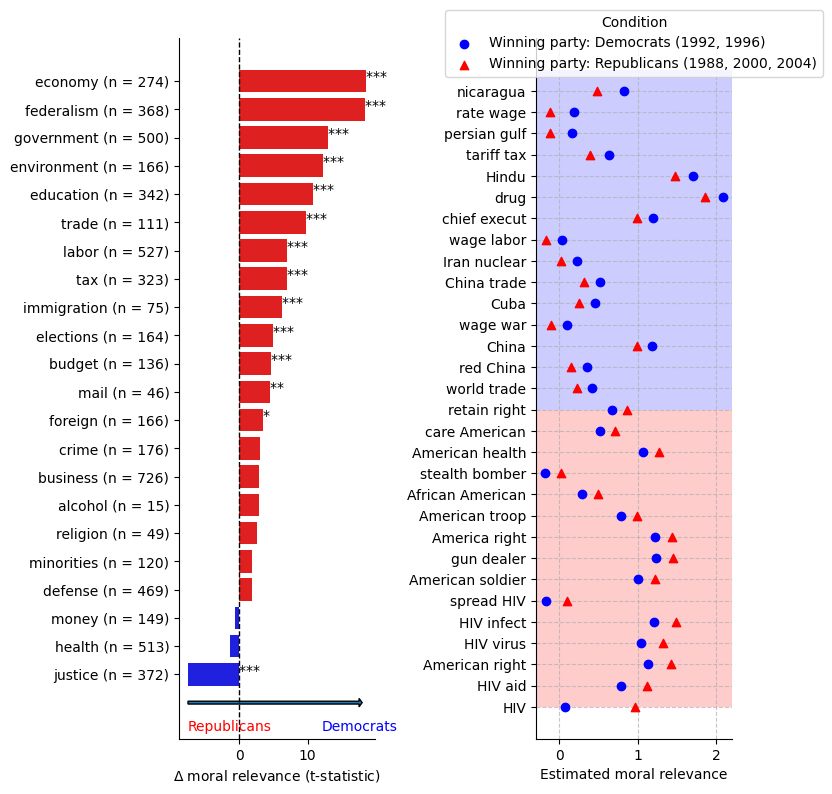

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes[0]
sns.barplot(
    y="Category",
    x="t",
    data=relevance_df.sort_values(by="t", ascending=False),
    hue="hue",
    ax=ax,
    palette={"blue", "red"},
)

ax.legend_ = None
ax.axvline(0, color="black", linewidth=1, linestyle="--")
for i, row in relevance_df.sort_values(by="t", ascending=False).iterrows():
    star = ""
    if row["reject"] == True:
        if row["correct_p"] < 0.001:
            star = "***  "
        elif row["correct_p"] < 0.01:
            star = "**  "
        elif row["correct_p"] < 0.05:
            star = "*  "

    ax.text(y=row["Category"], x=max(0, row["t"]), s=star)

ax.set_ylabel("")
ax.arrow(-7.5, 22, 25, 0, width=0.1)
ax.text(
    x=-7.5,
    y=23,
    s="Republicans",
    color="red",
)
ax.text(
    x=12,
    y=23,
    s="Democrats",
    color="blue",
)
ax.set_xlabel(r"$\Delta$ moral relevance (t-statistic)")
sns.despine()
ax = axes[1]


span_1 = plot_df.loc[plot_df.relevance_diff > 0]
ax.axhspan(0, len(span_1) - 1, facecolor="red", alpha=0.2)
ax.axhspan(len(span_1) - 1, len(plot_df), facecolor="blue", alpha=0.2)

ax.scatter(
    y=plot_df.word,
    x=plot_df["previous_link_blue_election"],
    color="blue",
    label="Winning party: Democrats (1992, 1996)",
    zorder=3,
    marker="o",
)
ax.scatter(
    y=plot_df.word,
    x=plot_df["previous_link_red_election"],
    color="red",
    label="Winning party: Republicans (1988, 2000, 2004)",
    marker="^",
    zorder=3,
)


ax.set_xlabel("Estimated moral relevance")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend(title="Condition", loc="upper center", bbox_to_anchor=(0.5, 1.05))

# Show the plot
plt.tight_layout()

plt.show()

## Let's study how moral relevance changes after the elections across topics and election outcomes

In [26]:
# Let's predict the moral relevance scores based on topics and election outcomes

In [27]:
import statsmodels.formula.api as smf

In [28]:
election_years = [1988, 1992, 1996, 2000, 2004]


def get_last_election(year):
    return max([int(e) for e in election_years if e <= year], default=None)

In [29]:
blue_years, red_years

({1992, 1996}, {1988, 2000, 2004})

In [30]:
small_ts_df = small_ts_df.loc[small_ts_df.property == "previous_link"].reset_index(
    drop=True,
)  # Only focusing on moral relevance scores

In [31]:
small_ts_df["category"] = small_ts_df["words"].apply(
    lambda w: topic_keywords[w] if w in topic_keywords else "other",
)
small_ts_df = small_ts_df.loc[small_ts_df.category != "other"]

In [32]:
new_df = small_ts_df.copy(deep=True)
new_df["year"] = new_df["year"] + 1

small_joint_df = small_ts_df.merge(
    new_df,
    on=[
        "words",
        "category",
        "year",
        "property",
    ],
    how="inner",
    suffixes=("_2", "_1"),
)
small_joint_df["year_1"] = small_joint_df["year"] - 1
small_joint_df.sample(10)

,words,year,property,outputs_z_2,count_2,category,outputs_z_1,count_1,year_1
10339,assist farmer,1996,previous_link,0.542558,2246.625000,business,0.599718,2413.375000,1995
117100,medic doctor,2002,previous_link,0.968391,3183.107143,health,0.970578,3197.750000,2001
132093,right oblig,1993,previous_link,1.300004,3885.125000,justice,1.270933,3237.733333,1992
49378,economi futur,1988,previous_link,-0.439230,9502.500000,economy,-0.449624,9628.200000,1987
164639,tax act,1993,previous_link,0.442260,2559.010490,tax,0.460153,2883.730769,1992
91326,war afghanistan,1993,previous_link,0.051012,811.788462,foreign,0.131340,931.160000,1992
35226,defens fund,2006,previous_link,0.770182,3131.738095,defense,0.725261,3990.357143,2005
37348,intellig gather,1992,previous_link,0.273830,1513.333333,defense,0.256029,1748.333333,1991
60596,loan student,1990,previous_link,-0.053120,16171.000000,education,0.008198,16595.500000,1989
106294,provid medicar,2007,previous_link,1.396967,1137.416667,health,1.429677,2688.583333,2006


In [33]:
small_joint_df["post_election"] = small_joint_df["year_1"].apply(
    lambda x: 1 if x in election_years else 0,
)  # Is the previous year an election year?
small_joint_df = small_joint_df.loc[small_joint_df["post_election"] == 1]
small_joint_df["election_result"] = small_joint_df["year_1"].apply(
    lambda x: 1 if x in red_years else 0,
)  # Who won the election in the previous year?

In [34]:
small_joint_df["moral_difference"] = (
    small_joint_df["outputs_z_2"] - small_joint_df["outputs_z_1"]
)

In [35]:
base_model = smf.mixedlm(
    "moral_difference ~ outputs_z_1 +  C(election_result) + C(category) + C(election_result):C(category)",
    small_joint_df,
    groups=small_joint_df["year"],
)
result = base_model.fit()
print(result.summary())

/home/armzn/venv2/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/armzn/venv2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/armzn/venv2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                            Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           moral_difference
No. Observations:             43042             Method:                       REML            
No. Groups:                   5                 Scale:                        0.0067          
Min. group size:              8554              Log-Likelihood:               46422.0467      
Max. group size:              8673              Converged:                    Yes             
Mean group size:              8608.4                                                          
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           0.005    0.015   0.375 0.70

In [36]:
# Let's calcualte the R2 score
from sklearn.metrics import r2_score

prediction = result.predict()
r2 = r2_score(small_joint_df["moral_difference"], prediction)
r2

0.06172961196264393